The amount of input data: 1331


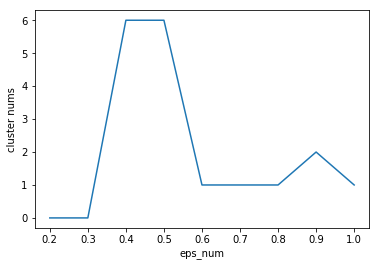

Estimated number of clusters: 6
Estimated number of noise points: 1243
the cluster 0's cluster mean is [273.33751941 -18.63888147   2.48025992  -1.4834219   -0.36191661], and the standard deviation is [0.02649963 0.04567765 0.25703727 1.51729223 2.08758996]
the cluster 1's cluster mean is [ 2.73340005e+02 -1.83832271e+01  2.77077464e+00 -1.00899240e+00
 -7.88072894e-02], and the standard deviation is [0.03656016 0.04486976 0.40963389 1.48119222 1.79805019]
the cluster 2's cluster mean is [273.04851879 -18.7525071    2.76170265  -0.84445128  -0.93486043], and the standard deviation is [0.0339843  0.03724664 0.54283262 1.69944159 2.52718284]
the cluster 3's cluster mean is [272.9141496  -18.90090675   2.3304213   -0.88257799  -6.64791622], and the standard deviation is [0.04299626 0.03632795 0.21147875 1.32244644 3.05589454]
the cluster 4's cluster mean is [272.9312784  -18.61461526   3.01972071  -1.51753693  -0.53364083], and the standard deviation is [0.05912131 0.04367323 0.69261896 1

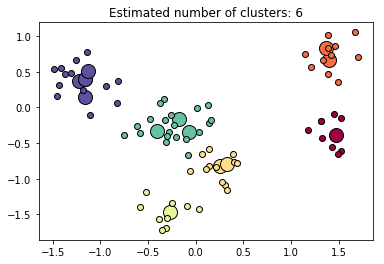

[[ 1.38747486  0.46299506 -0.56325093  0.0968944   0.33093667]
 [ 1.21454228  0.56072429 -0.77320286  0.00648113  0.25034379]
 [ 1.49334165  0.36128149 -0.58439521  0.05725208  0.40538622]
 [ 1.33608484  0.66362453 -0.49077347  0.00362398  0.58112951]
 [ 1.41607811  0.73592256 -0.19561801 -0.06037759  0.44930223]
 [ 1.3963677   0.66259206 -0.54706578 -0.00598901  0.33985455]
 [ 1.70485277  0.71088458 -0.5501071   0.143678    0.14652644]
 [ 1.14880885  0.75616399 -0.47591545  0.17342769  0.22494766]
 [ 1.67479811  1.05427208 -0.51515377  0.22852447  0.22509609]
 [ 1.39068459  1.02036396 -0.6821072   0.39409988  0.42645182]
 [ 1.3842115   0.83376815 -0.54105358  0.30735102  0.2932568 ]
 [ 1.36276956  0.82977821 -0.56421193  0.18787105  0.30972387]
 [ 1.46072478  0.86339661 -0.52656929 -0.06007099  0.41150497]]


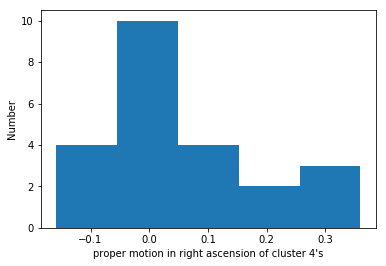

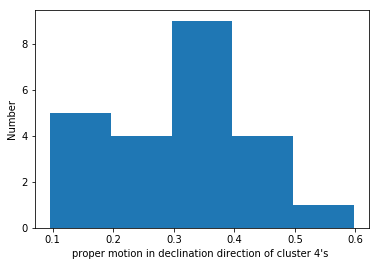

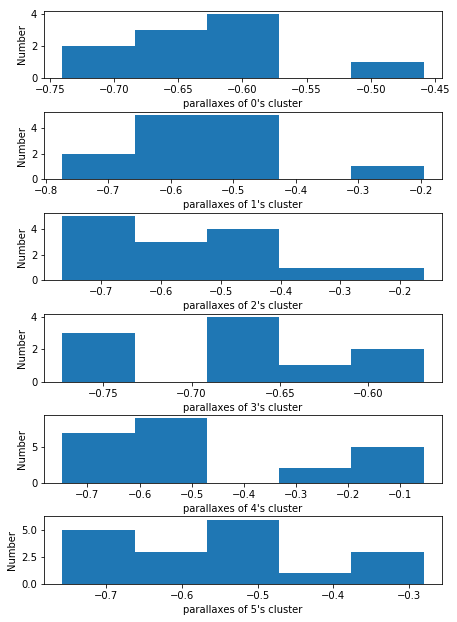

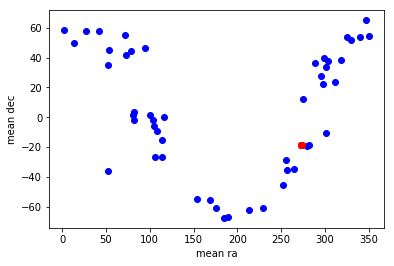

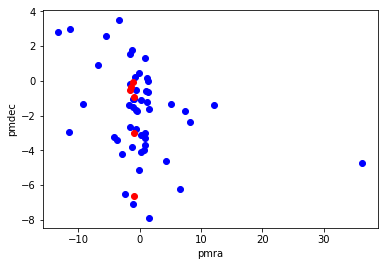

In [30]:
from astroquery.gaia import Gaia

import numpy as np
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import h5py
import os

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

hdf_save_path='./tst.hdf'

def get_gaia_data():
    ra = 272.96
    dec = -18.53932068
    angle_first = 0.5

    job = Gaia.launch_job_async("SELECT ra, dec, parallax, pmra, pmdec \
                                FROM gaiadr2.gaia_source \
                                WHERE 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',"+str(ra) +" , "+str(dec) +" , "+ str(angle_first)+" )) \
                                and parallax > 2 and abs(parallax_over_error) > 5 and phot_g_mean_mag <18")

    print(job)
    r = job.get_results()
    print(r)
    # for line in r:
    #     print(line)
    if os.path.exists(hdf_save_path):
        os.remove(hdf_save_path)

    r.write('tst.hdf', path=hdf_save_path,format='hdf5')

def read_from_hdf():
    with h5py.File('./tst.hdf', "r") as f:
        # List all groups
        # print("Keys: %s" % f.keys())
        a_group_key = list(f.keys())[0]

        # Get the data
        data = list(f[a_group_key])

        input_data = []
        for item in data:
            input_data.append(list(item))

    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp = imp.fit(input_data)
    input_data = imp.transform(input_data)
    print('The amount of input data: %d' % len(input_data))
    return input_data

def DBSCAN_clusters(input_data):
    from sklearn.cluster import DBSCAN
    import matplotlib.pyplot as plt
    from pylab import xscale
    %matplotlib inline

    X = StandardScaler().fit_transform(input_data)

    eps_list=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    eps_estimate_result=[]
    for eps_item in eps_list:
        db = DBSCAN(eps=eps_item, min_samples=10).fit(X)
        n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        eps_estimate_result.append(n_clusters)

    plt.plot(eps_list,eps_estimate_result)
    plt.xlabel('eps_num')
    plt.ylabel('cluster nums')
    plt.gcf()
    plt.savefig('./figures/'+"cluster_nums_and_eps")
    plt.show()

    # Compute DBSCAN
    db = DBSCAN(eps=0.4, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)


    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    unique_labels.remove(-1)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    def plot_histogram(inputs,x_label):
        number_of_bins=5
        plt.hist(inputs, bins=number_of_bins)
        # xscale('log')
        plt.xlabel(x_label)
        plt.ylabel('Number')
        plt.gcf()
        plt.savefig('./figures/'+x_label)
        plt.show()

    def plot_separately_histogram(inputs,k):
        # plot for separately histogram for parallaxes
        number_of_bins = 5
        i=1
        for key,value in inputs.items():
            plt.subplot(k,1,i)
            plt.subplots_adjust(left=0.04, top= 2, right = 0.96, bottom = 0.01, wspace = 0.02, hspace = 0.5)
            i+=1
            plt.hist(value[:,2],bins=number_of_bins)
            plt.xlabel("parallaxes of "+ str(key)+"'s cluster")
            plt.ylabel("Number")
        plt.gcf()
        plt.savefig('./figures/'+"parallaxes_separately_histogram")
        plt.show()

    def get_Cantat():
        from astroquery.vizier import Vizier
        table=Vizier.get_catalogs('J/A+A/618/A93/table1')
        # table=Vizier.get_catalogs('J/A+A/618/A93/members')
        table_item=table[0]
        cantat_cluster_coordinates=[]
        for item in zip(table_item['RAJ2000'],table_item['DEJ2000'],table_item['pmRA'],table_item['pmDE']):
            cantat_cluster_coordinates.append([item[0],item[1],item[2],item[3]])
        return np.array(cantat_cluster_coordinates)

    def plot_Cantat_and_self(cantat_cluster_coordinates,cluster_mean,ra_dec=True):
        cluster_mean_list=np.array([value.tolist() for key,value in cluster_mean.items()])

        if ra_dec:
            plt.scatter(cantat_cluster_coordinates[:, 0], cantat_cluster_coordinates[:, 1], color='blue')
            plt.scatter(cluster_mean_list[:, 0], cluster_mean_list[:, 1], color='red')
            plt.xlabel("mean ra")
            plt.ylabel("mean dec")
        else:
            plt.scatter(cantat_cluster_coordinates[:, -2], cantat_cluster_coordinates[:, -1], color='blue')
            plt.scatter(cluster_mean_list[:, -2], cluster_mean_list[:, -1], color='red')
            plt.xlabel("pmra")
            plt.ylabel("pmdec")
        plt.gcf()
        if ra_dec:
            plt.savefig('./figures/'+"mean ra & dec")
        else:
            plt.savefig('./figures/'+"mean pmra & pmdec")
        plt.show()

    cluster_mean={}
    cluster_standard={}
    cluster_items_all={}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        cluster_items_source=input_data[class_member_mask]
        cluster_items=X[class_member_mask]

        cluster_mean[k]=np.mean(cluster_items_source,axis=0)
        cluster_standard[k] = np.std(cluster_items_source, axis=0)
        cluster_items_all[k]=cluster_items
        print("the cluster " + str(k) + "'s cluster mean is " + str(cluster_mean[k]) + ", and the standard deviation is " + str(cluster_standard[k]))
       

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.gcf()
    plt.savefig('./figures/'+"clustres")
    plt.show()
    
    print((cluster_items_all[1]))
    
    # change the item number to get the figures for different clusters
    plot_histogram(cluster_items_all[4][:,-2], 'proper motion in right ascension of cluster 4\'s')
    plot_histogram(cluster_items_all[4][:,-1], 'proper motion in declination direction of cluster 4\'s ')
    plot_separately_histogram(cluster_items_all,len(unique_labels))
    cantat_cluster_coordinates=get_Cantat()
    plot_Cantat_and_self(cantat_cluster_coordinates,cluster_mean)
    plot_Cantat_and_self(cantat_cluster_coordinates,cluster_mean,ra_dec=False)

if __name__=='__main__':
    #get_gaia_data()
    input_data=read_from_hdf()
    DBSCAN_clusters(input_data)